# Video Games Sales Analysis

After analyzing the data with the help of Tableau, linear regression models will be created in this notebook to try to predict which parameters are most decisive for a video game to be a sales success.

In [22]:
#lib imports

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import norm, skew 

%matplotlib inline
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore warnings

In [23]:
#csv read
vg_sales_df = pd.read_csv('Video_Games.csv')
vg_sales_df.columns= vg_sales_df.columns.str.lower()
vg_sales_df.head()

,unnamed: 0,name,platform,year_of_release,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count,developer,rating,manufacturer
0,0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E,Nintendo
1,1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,Nintendo
2,2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,Nintendo
3,3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E,Nintendo
4,4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,Nintendo


In [24]:
#checking the df's shape

vg_sales_df.shape

(16719, 18)

In [25]:
#changind the first column name to "rank" and adjusting the values
vg_sales_df.rename(columns={"unnamed: 0": "rank"}, inplace=True)
vg_sales_df['rank'] = vg_sales_df['rank'] + 1 


vg_sales_df.head()

,rank,name,platform,year_of_release,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count,developer,rating,manufacturer
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E,Nintendo
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,Nintendo
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,Nintendo
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E,Nintendo
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,Nintendo


After importing the csv and converting it to DataFrame, the global_sales points will be plotted to see if the data distribution approximates a normal distribution.

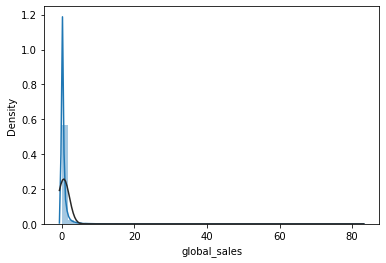

In [26]:
sns.distplot(vg_sales_df['global_sales'] , fit=norm);

It is already possible to see that it does not appear to be a normal distribution, but no transformation will be done initially, so that first a brief analysis and cleaning of the data will be done.

In addition to the plotting, we will do a quick heatmap analysis of the quantitative variables, to see if there is any relationship between them (and more importantly, between any of them and global_sales, which is our dependent variable).

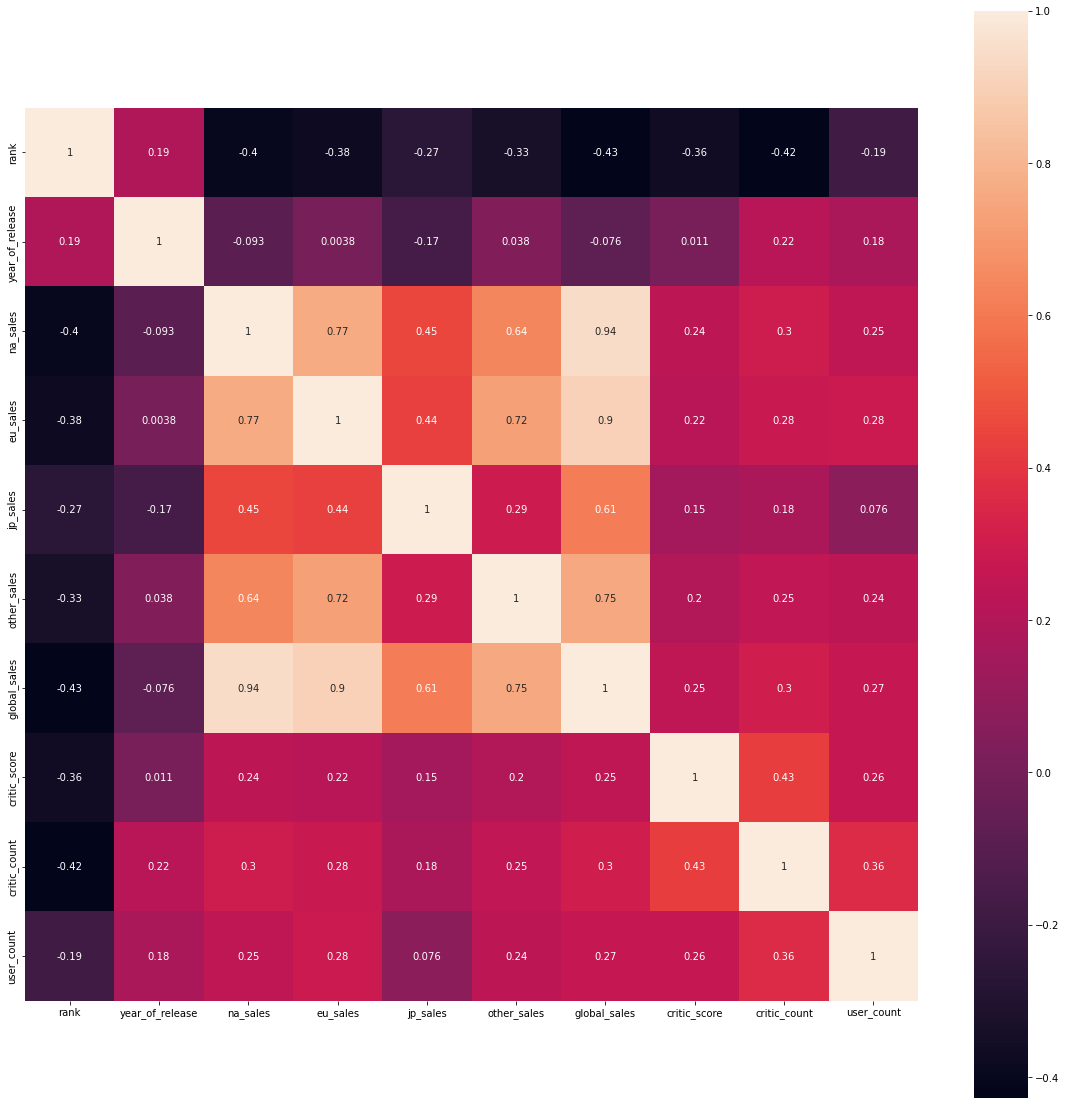

In [27]:
plt.figure(figsize=(20, 20))
p = sns.heatmap(vg_sales_df.corr(), annot=True, square=True)

In the heatmap, the only values that have a relevant relationship, are the regional sales themselves, which doesn't tell us much, since the amount of global_sales is just the sum of all the others.

# Data Cleaning

To make it easier to work with the data, a grouping of the platforms by "manufacturer" will be done.

In [28]:
#quick check of all platforms present in the dataframe
vg_sales_df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [29]:
#creation of the new manufacturer column, grouping platforms from the same manufacturer
vg_sales_df.loc[vg_sales_df['platform'] == 'Wii', 'manufacturer'] = 'Nintendo'
vg_sales_df.loc[vg_sales_df['platform'] == 'NES', 'manufacturer'] = 'Nintendo'
vg_sales_df.loc[vg_sales_df['platform'] == 'GB', 'manufacturer'] = 'Nintendo'
vg_sales_df.loc[vg_sales_df['platform'] == 'DS', 'manufacturer'] = 'Nintendo'
vg_sales_df.loc[vg_sales_df['platform'] == 'X360', 'manufacturer'] = 'Microsoft'
vg_sales_df.loc[vg_sales_df['platform'] == 'PS3', 'manufacturer'] = 'Sony'
vg_sales_df.loc[vg_sales_df['platform'] == 'PS2', 'manufacturer'] = 'Sony'
vg_sales_df.loc[vg_sales_df['platform'] == 'SNES', 'manufacturer'] = 'Nintendo'
vg_sales_df.loc[vg_sales_df['platform'] == 'GBA', 'manufacturer'] = 'Nintendo'
vg_sales_df.loc[vg_sales_df['platform'] == 'PS4', 'manufacturer'] = 'Sony'
vg_sales_df.loc[vg_sales_df['platform'] == '3DS', 'manufacturer'] = 'Nintendo'
vg_sales_df.loc[vg_sales_df['platform'] == 'N64', 'manufacturer'] = 'Nintendo'
vg_sales_df.loc[vg_sales_df['platform'] == 'PS', 'manufacturer'] = 'Sony'
vg_sales_df.loc[vg_sales_df['platform'] == 'XB', 'manufacturer'] = 'Microsoft'
vg_sales_df.loc[vg_sales_df['platform'] == 'PC', 'manufacturer'] = 'PC'
vg_sales_df.loc[vg_sales_df['platform'] == '2600', 'manufacturer'] = 'Atari'
vg_sales_df.loc[vg_sales_df['platform'] == 'PSP', 'manufacturer'] = 'Sony'
vg_sales_df.loc[vg_sales_df['platform'] == 'XOne', 'manufacturer'] = 'Microsoft'
vg_sales_df.loc[vg_sales_df['platform'] == 'WiiU', 'manufacturer'] = 'Nintendo'
vg_sales_df.loc[vg_sales_df['platform'] == 'GC', 'manufacturer'] = 'Nintendo'
vg_sales_df.loc[vg_sales_df['platform'] == 'GEN', 'manufacturer'] = 'SEGA'
vg_sales_df.loc[vg_sales_df['platform'] == 'DC', 'manufacturer'] = 'SEGA'
vg_sales_df.loc[vg_sales_df['platform'] == 'PSV', 'manufacturer'] = 'Sony'
vg_sales_df.loc[vg_sales_df['platform'] == 'SAT', 'manufacturer'] = 'SEGA'
vg_sales_df.loc[vg_sales_df['platform'] == 'SCD', 'manufacturer'] = 'SNK'
vg_sales_df.loc[vg_sales_df['platform'] == 'WS', 'manufacturer'] = 'Bandai'
vg_sales_df.loc[vg_sales_df['platform'] == 'NG', 'manufacturer'] = 'SNK'
vg_sales_df.loc[vg_sales_df['platform'] == 'TG16', 'manufacturer'] = 'NEC'
vg_sales_df.loc[vg_sales_df['platform'] == '3DO', 'manufacturer'] = '3DO Company'
vg_sales_df.loc[vg_sales_df['platform'] == 'GG', 'manufacturer'] = 'SEGA'
vg_sales_df.loc[vg_sales_df['platform'] == 'PCFX', 'manufacturer'] = 'NEC'
vg_sales_df['manufacturer'].unique()

array(['Nintendo', 'Microsoft', 'Sony', 'PC', 'Atari', 'SEGA', 'SNK',
       'Bandai', 'NEC', '3DO Company'], dtype=object)

This reduces the number of 31 platforms to 10 manufacturers

Now let's analyze the number of null values in the dataset.

In [30]:
#absolute number of null values
vg_sales_df.isnull().sum()

rank                  0
name                  2
platform              0
year_of_release     269
genre                 2
publisher            54
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
global_sales          0
critic_score       8582
critic_count       8582
user_score         6704
user_count         9129
developer          6623
rating             6769
manufacturer          0
dtype: int64

In [31]:
#percentage amount of null values
(vg_sales_df.isnull().sum() / len(vg_sales_df)) * 100

rank                0.000000
name                0.011962
platform            0.000000
year_of_release     1.608948
genre               0.011962
publisher           0.322986
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
global_sales        0.000000
critic_score       51.330821
critic_count       51.330821
user_score         40.098092
user_count         54.602548
developer          39.613613
rating             40.486871
manufacturer        0.000000
dtype: float64

We can notice that many variables have high amounts of null values, which is a problem.

First, we will filter the manufacturers, to analyze the ones that are still active on the market, because for our problem, it would be wrong to work with the possibility of releasing a game on a platform that no longer exists.

In [32]:
vg_sales_df = vg_sales_df[(vg_sales_df['manufacturer'] == 'Nintendo') | (vg_sales_df['manufacturer'] == 'Microsoft') | (vg_sales_df['manufacturer'] == 'Sony') | (vg_sales_df['manufacturer'] == 'PC')]

print(pd.value_counts(vg_sales_df["manufacturer"]))

print(vg_sales_df.shape)

#checking again the % of nulls
(vg_sales_df.isnull().sum() / len(vg_sales_df)) * 100

Sony         6723
Nintendo     6271
Microsoft    2333
PC            974
Name: manufacturer, dtype: int64
(16301, 18)


rank                0.000000
name                0.000000
platform            0.000000
year_of_release     1.545917
genre               0.000000
publisher           0.331268
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
global_sales        0.000000
critic_score       50.168701
critic_count       50.168701
user_score         38.647936
user_count         53.524324
developer          38.151034
rating             39.046684
manufacturer        0.000000
dtype: float64

Despite the reduction of row totals, the amount of nulls did not reduce to an acceptable value.

It would be wrong to fill this large amount of null values with metrics such as mean, median and mode, so it was decided to discard the null values and work with what remains of the data.

In [33]:
vg_sales_df = vg_sales_df.dropna(subset=['critic_score'])
print((vg_sales_df.isnull().sum() / len(vg_sales_df)) * 100)
vg_sales_df.shape

rank                0.000000
name                0.000000
platform            0.000000
year_of_release     1.895851
genre               0.000000
publisher           0.049243
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
global_sales        0.000000
critic_score        0.000000
critic_count        0.000000
user_score          0.467807
user_count         13.788009
developer           0.073864
rating              1.021790
manufacturer        0.000000
dtype: float64


(8123, 18)

With the remaining 8123 rows, the number of null values has reduced quite a bit, but there are still some that we need to deal with. 

To do this we will fill in (now with a smaller % of nulls) with "manufactured" values based on the rest of the data.

In [34]:
# for category, publisher and developer, let's assume that the few blank values are among the most frequent (mode)
vg_sales_df['rating'] = vg_sales_df['rating'].fillna(vg_sales_df['rating'].mode()[0])
vg_sales_df['publisher'] = vg_sales_df['publisher'].fillna(vg_sales_df['publisher'].mode()[0])
vg_sales_df['developer'] = vg_sales_df['developer'].fillna(vg_sales_df['developer'].mode()[0])

#for the launch year the median will be used
vg_sales_df['year_of_release'] = vg_sales_df['year_of_release'].fillna(vg_sales_df['year_of_release'].median())

#user_score and user_count will use the average (note: in user_score there is a tbd value, about games that haven't received a score yet
#which will also be replaced)

vg_sales_df['user_score'] = vg_sales_df['user_score'].replace('tbd', None)
vg_sales_df['user_score'] = vg_sales_df['user_score'].fillna(vg_sales_df['user_score'].median())
vg_sales_df['user_count'] = vg_sales_df['user_count'].fillna(vg_sales_df['user_count'].median())

print((vg_sales_df.isnull().sum() / len(vg_sales_df)) * 100)
vg_sales_df.shape

rank               0.0
name               0.0
platform           0.0
year_of_release    0.0
genre              0.0
publisher          0.0
na_sales           0.0
eu_sales           0.0
jp_sales           0.0
other_sales        0.0
global_sales       0.0
critic_score       0.0
critic_count       0.0
user_score         0.0
user_count         0.0
developer          0.0
rating             0.0
manufacturer       0.0
dtype: float64


(8123, 18)

The next step is to deal with the categorical variables.

The 'publisher' and 'developer' column have a lot of unique values, which would cause a lot of dummy columns, so these two variables will be ignored at this point.

The 'platform' column has been simplified to the 'manufacturer' column, so it will also be ignored.

This leaves us with the columns 'rating', 'manufacturer' and 'genre'.

In [35]:
#creating "dummy" columns for the variables rating, manufacturer and genre
vg_sales_df = pd.get_dummies(data=vg_sales_df, columns=['rating', 'manufacturer', 'genre'])
vg_sales_df.columns= vg_sales_df.columns.str.lower()
print(vg_sales_df.shape) 
vg_sales_df.head()

(8123, 38)


,rank,name,platform,year_of_release,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,...,genre_fighting,genre_misc,genre_platform,genre_puzzle,genre_racing,genre_role-playing,genre_shooter,genre_simulation,genre_sports,genre_strategy
0,1,Wii Sports,Wii,2006.0,Nintendo,41.36,28.96,3.77,8.45,82.53,...,0,0,0,0,0,0,0,0,1,0
2,3,Mario Kart Wii,Wii,2008.0,Nintendo,15.68,12.76,3.79,3.29,35.52,...,0,0,0,0,1,0,0,0,0,0
3,4,Wii Sports Resort,Wii,2009.0,Nintendo,15.61,10.93,3.28,2.95,32.77,...,0,0,0,0,0,0,0,0,1,0
6,7,New Super Mario Bros.,DS,2006.0,Nintendo,11.28,9.14,6.50,2.88,29.80,...,0,0,1,0,0,0,0,0,0,0
7,8,Wii Play,Wii,2006.0,Nintendo,13.96,9.18,2.93,2.84,28.92,...,0,1,0,0,0,0,0,0,0,0


For our models, we will not use all columns, so we can discard them:
- Rank
- Name
- Platform
- Publisher
- Developer
- NA_Sales
- EU_Sales
- JP_Sales
- Other_Sales

In [36]:
#now let's drop the columns that don't matter for the model:

vg_sales_df = vg_sales_df.drop(['rank', 'name', 'publisher', 'platform', 'developer', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales'], axis=1)
vg_sales_df.head()

,year_of_release,global_sales,critic_score,critic_count,user_score,user_count,rating_ao,rating_e,rating_e10+,rating_k-a,...,genre_fighting,genre_misc,genre_platform,genre_puzzle,genre_racing,genre_role-playing,genre_shooter,genre_simulation,genre_sports,genre_strategy
0,2006.0,82.53,76.0,51.0,8,322.0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2008.0,35.52,82.0,73.0,8.3,709.0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2009.0,32.77,80.0,73.0,8,192.0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
6,2006.0,29.80,89.0,65.0,8.5,431.0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
7,2006.0,28.92,58.0,41.0,6.6,129.0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [37]:
print(vg_sales_df.columns)

Index(['year_of_release', 'global_sales', 'critic_score', 'critic_count',
       'user_score', 'user_count', 'rating_ao', 'rating_e', 'rating_e10+',
       'rating_k-a', 'rating_m', 'rating_rp', 'rating_t',
       'manufacturer_microsoft', 'manufacturer_nintendo', 'manufacturer_pc',
       'manufacturer_sony', 'genre_action', 'genre_adventure',
       'genre_fighting', 'genre_misc', 'genre_platform', 'genre_puzzle',
       'genre_racing', 'genre_role-playing', 'genre_shooter',
       'genre_simulation', 'genre_sports', 'genre_strategy'],
      dtype='object')


# Modeling

#### Model 1

For the first model, we will use all variables for global_sales prediction.

In [38]:
#Let's create the variables X and y to start modeling

X = vg_sales_df[['year_of_release', 'critic_score', 'critic_count',
       'user_score', 'user_count', 'rating_ao', 'rating_e', 'rating_e10+',
       'rating_k-a', 'rating_m', 'rating_rp', 'rating_t',
       'manufacturer_microsoft', 'manufacturer_nintendo', 'manufacturer_pc',
       'manufacturer_sony', 'genre_action', 'genre_adventure',
       'genre_fighting', 'genre_misc', 'genre_platform', 'genre_puzzle',
       'genre_racing', 'genre_role-playing', 'genre_shooter',
       'genre_simulation', 'genre_sports', 'genre_strategy']]

y = vg_sales_df[['global_sales']]

print(X.shape)
print(y.shape)

(8123, 28)
(8123, 1)


In [39]:
#division of the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

#double-check that the division was done correctly
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(5686, 28)
(5686, 1)
(2437, 28)
(2437, 1)


Before we start training the model, let's check whether the distribution on a logarithmic basis is closer to a normal distribution.

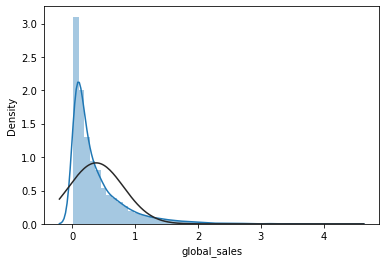

In [40]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

sns.distplot(np.log1p(vg_sales_df['global_sales']) , fit=norm);

The distribution is still not normal, but it seems to have become slightly closer. So we will use the logarithmic basis and analyze it at the end.

In [41]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("R2 : %.2f" % np.expm1(model.score(X_test,y_test)))
print("RMSE: %.2f" % np.expm1(mean_squared_error(y_test, model.predict(X_test), squared=False)))

R2 : 0.46
RMSE: 0.43


#### Model 2

For the second model, we will do a combination of the variables manufacturer and genre, to understand if this improves the model and also already gives us an answer of what is the best combination of choices (manufacturer x genre) when creating a game.

In [43]:
df_comb = vg_sales_df.copy()
df_comb = df_comb.drop(['year_of_release', 'critic_score', 'critic_count',
       'user_score', 'user_count', 'rating_ao', 'rating_e', 'rating_e10+',
       'rating_k-a', 'rating_m', 'rating_rp', 'rating_t'], axis=1)
df_comb.head()

,global_sales,manufacturer_microsoft,manufacturer_nintendo,manufacturer_pc,manufacturer_sony,genre_action,genre_adventure,genre_fighting,genre_misc,genre_platform,genre_puzzle,genre_racing,genre_role-playing,genre_shooter,genre_simulation,genre_sports,genre_strategy
0,82.53,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,35.52,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,32.77,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,29.80,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,28.92,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [44]:
df_comb.shape

(8123, 17)

In [45]:
# creating new columns with the combination of manufacturer and genre

# List with names of manufacturer columns
colunas_manufacturer = ['manufacturer_microsoft', 'manufacturer_nintendo', 'manufacturer_pc', 'manufacturer_sony']

# List with the genre column names
colunas_genre = ['genre_action', 'genre_adventure', 'genre_fighting', 'genre_misc', 'genre_platform', 'genre_puzzle', 
                'genre_racing', 'genre_role-playing', 'genre_shooter', 'genre_simulation', 'genre_sports', 'genre_strategy']

#loop that runs through the manufacturer columns
for coluna_manufacturer in colunas_manufacturer:
    #loop that runs through the genre columns
    for coluna_genre in colunas_genre:                  
        
        # new column in DF with the column name resulting from the multiplication of the manufacturer and genre columns
        nome_nova_coluna = coluna_manufacturer + '_' + coluna_genre
        
        # multiply the values in each row and save to the new column
        df_comb[nome_nova_coluna] = df_comb[coluna_manufacturer] * df_comb[coluna_genre]

print(df_comb.columns)

Index(['global_sales', 'manufacturer_microsoft', 'manufacturer_nintendo',
       'manufacturer_pc', 'manufacturer_sony', 'genre_action',
       'genre_adventure', 'genre_fighting', 'genre_misc', 'genre_platform',
       'genre_puzzle', 'genre_racing', 'genre_role-playing', 'genre_shooter',
       'genre_simulation', 'genre_sports', 'genre_strategy',
       'manufacturer_microsoft_genre_action',
       'manufacturer_microsoft_genre_adventure',
       'manufacturer_microsoft_genre_fighting',
       'manufacturer_microsoft_genre_misc',
       'manufacturer_microsoft_genre_platform',
       'manufacturer_microsoft_genre_puzzle',
       'manufacturer_microsoft_genre_racing',
       'manufacturer_microsoft_genre_role-playing',
       'manufacturer_microsoft_genre_shooter',
       'manufacturer_microsoft_genre_simulation',
       'manufacturer_microsoft_genre_sports',
       'manufacturer_microsoft_genre_strategy',
       'manufacturer_nintendo_genre_action',
       'manufacturer_nintendo_gen

In [46]:
# again we will do the process of creating the variables X and y for modeling
X2 = df_comb[['manufacturer_microsoft_genre_fighting',
       'manufacturer_microsoft_genre_misc',
       'manufacturer_microsoft_genre_simulation',
       'manufacturer_nintendo_genre_fighting',
       'manufacturer_nintendo_genre_misc',
       'manufacturer_nintendo_genre_simulation',
       'manufacturer_sony_genre_fighting',
       'manufacturer_sony_genre_misc', 'manufacturer_sony_genre_simulation']]

y2 = df_comb[['global_sales']]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, random_state = 0)

y2_train = np.log1p(y2_train)
y2_test = np.log1p(y2_test)

model2 = LinearRegression()
model2.fit(X2_train, y2_train)
predictions = model2.predict(X2_test)
print("R2 : %.2f" % np.expm1(model2.score(X2_test,y2_test)))
print("RMSE: %.2f" % np.expm1(mean_squared_error(y2_test, model2.predict(X2_test), squared=False)))

R2 : 0.01
RMSE: 0.57


#### Model 3

The third model will be done by creating a separate model for each dummy of the combinations, applying it only to the corresponding rows (in the rows where the values are 1).

In [47]:
#create separate dataframes to start the proposed modeling
df_comb_1 = df_comb[df_comb['manufacturer_microsoft_genre_fighting'] == 1]
df_comb_2 = df_comb[df_comb["manufacturer_microsoft_genre_misc"] == 1]
df_comb_3 = df_comb[df_comb["manufacturer_microsoft_genre_simulation"] == 1]
df_comb_4 = df_comb[df_comb["manufacturer_nintendo_genre_fighting"] == 1]
df_comb_5 = df_comb[df_comb["manufacturer_nintendo_genre_misc"] == 1]
df_comb_6 = df_comb[df_comb["manufacturer_nintendo_genre_simulation"] == 1]
df_comb_7 = df_comb[df_comb["manufacturer_sony_genre_fighting"] == 1]
df_comb_8 = df_comb[df_comb["manufacturer_sony_genre_misc"] == 1]
df_comb_9 = df_comb[df_comb["manufacturer_sony_genre_simulation"] == 1]

In [48]:
# creation of X and y variables for each new dataframe
X1 = df_comb_1[['manufacturer_microsoft_genre_fighting',
       'manufacturer_microsoft_genre_misc',
       'manufacturer_microsoft_genre_simulation',
       'manufacturer_nintendo_genre_fighting',
       'manufacturer_nintendo_genre_misc',
       'manufacturer_nintendo_genre_simulation',
       'manufacturer_sony_genre_fighting',
       'manufacturer_sony_genre_misc', 'manufacturer_sony_genre_simulation']]
y1 = df_comb_1["global_sales"]

X2 = df_comb_2[['manufacturer_microsoft_genre_fighting',
       'manufacturer_microsoft_genre_misc',
       'manufacturer_microsoft_genre_simulation',
       'manufacturer_nintendo_genre_fighting',
       'manufacturer_nintendo_genre_misc',
       'manufacturer_nintendo_genre_simulation',
       'manufacturer_sony_genre_fighting',
       'manufacturer_sony_genre_misc', 'manufacturer_sony_genre_simulation']]
y2 = df_comb_2["global_sales"]

X3 = df_comb_3[['manufacturer_microsoft_genre_fighting',
       'manufacturer_microsoft_genre_misc',
       'manufacturer_microsoft_genre_simulation',
       'manufacturer_nintendo_genre_fighting',
       'manufacturer_nintendo_genre_misc',
       'manufacturer_nintendo_genre_simulation',
       'manufacturer_sony_genre_fighting',
       'manufacturer_sony_genre_misc', 'manufacturer_sony_genre_simulation']]
y3 = df_comb_3["global_sales"]

X4 = df_comb_4[['manufacturer_microsoft_genre_fighting',
       'manufacturer_microsoft_genre_misc',
       'manufacturer_microsoft_genre_simulation',
       'manufacturer_nintendo_genre_fighting',
       'manufacturer_nintendo_genre_misc',
       'manufacturer_nintendo_genre_simulation',
       'manufacturer_sony_genre_fighting',
       'manufacturer_sony_genre_misc', 'manufacturer_sony_genre_simulation']]
y4 = df_comb_4["global_sales"]

X5 = df_comb_5[['manufacturer_microsoft_genre_fighting',
       'manufacturer_microsoft_genre_misc',
       'manufacturer_microsoft_genre_simulation',
       'manufacturer_nintendo_genre_fighting',
       'manufacturer_nintendo_genre_misc',
       'manufacturer_nintendo_genre_simulation',
       'manufacturer_sony_genre_fighting',
       'manufacturer_sony_genre_misc', 'manufacturer_sony_genre_simulation']]
y5 = df_comb_5["global_sales"]

X6 = df_comb_6[['manufacturer_microsoft_genre_fighting',
       'manufacturer_microsoft_genre_misc',
       'manufacturer_microsoft_genre_simulation',
       'manufacturer_nintendo_genre_fighting',
       'manufacturer_nintendo_genre_misc',
       'manufacturer_nintendo_genre_simulation',
       'manufacturer_sony_genre_fighting',
       'manufacturer_sony_genre_misc', 'manufacturer_sony_genre_simulation']]
y6 = df_comb_6["global_sales"]

X7 = df_comb_7[['manufacturer_microsoft_genre_fighting',
       'manufacturer_microsoft_genre_misc',
       'manufacturer_microsoft_genre_simulation',
       'manufacturer_nintendo_genre_fighting',
       'manufacturer_nintendo_genre_misc',
       'manufacturer_nintendo_genre_simulation',
       'manufacturer_sony_genre_fighting',
       'manufacturer_sony_genre_misc', 'manufacturer_sony_genre_simulation']]
y7 = df_comb_7["global_sales"]

X8 = df_comb_8[['manufacturer_microsoft_genre_fighting',
       'manufacturer_microsoft_genre_misc',
       'manufacturer_microsoft_genre_simulation',
       'manufacturer_nintendo_genre_fighting',
       'manufacturer_nintendo_genre_misc',
       'manufacturer_nintendo_genre_simulation',
       'manufacturer_sony_genre_fighting',
       'manufacturer_sony_genre_misc', 'manufacturer_sony_genre_simulation']]
y8 = df_comb_8["global_sales"]

X9 = df_comb_9[['manufacturer_microsoft_genre_fighting',
       'manufacturer_microsoft_genre_misc',
       'manufacturer_microsoft_genre_simulation',
       'manufacturer_nintendo_genre_fighting',
       'manufacturer_nintendo_genre_misc',
       'manufacturer_nintendo_genre_simulation',
       'manufacturer_sony_genre_fighting',
       'manufacturer_sony_genre_misc', 'manufacturer_sony_genre_simulation']]
y9 = df_comb_9["global_sales"]

In [49]:
# create a template and its respective training for each column
model1 = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()
model4 = LinearRegression()
model5 = LinearRegression()
model6 = LinearRegression()
model7 = LinearRegression()
model8 = LinearRegression()
model9 = LinearRegression()

model1.fit(X1, y1)
model2.fit(X2, y2)
model3.fit(X3, y3)
model4.fit(X4, y4)
model5.fit(X5, y5)
model6.fit(X6, y6)
model7.fit(X7, y7)
model8.fit(X8, y8)
model9.fit(X9, y9)

LinearRegression()

In [50]:
#calculation of the expected value for each dataframe and creation of the respective column
df_comb_1["gs_predicted"] = np.exp(model1.predict(X1))
df_comb_2["gs_predicted"] = np.exp(model2.predict(X2))
df_comb_3["gs_predicted"] = np.exp(model3.predict(X3))
df_comb_4["gs_predicted"] = np.exp(model4.predict(X4))
df_comb_5["gs_predicted"] = np.exp(model5.predict(X5))
df_comb_6["gs_predicted"] = np.exp(model6.predict(X6))
df_comb_7["gs_predicted"] = np.exp(model7.predict(X7))
df_comb_8["gs_predicted"] = np.exp(model8.predict(X8))
df_comb_9["gs_predicted"] = np.exp(model9.predict(X9))

In [51]:
# Check the MSE values for each model
print('1: ' + f'{np.sqrt(mean_squared_error(df_comb_1["global_sales"], df_comb_1["gs_predicted"]))}')
print('2: ' + f'{np.sqrt(mean_squared_error(df_comb_2["global_sales"], df_comb_2["gs_predicted"]))}')
print('3: ' + f'{np.sqrt(mean_squared_error(df_comb_3["global_sales"], df_comb_3["gs_predicted"]))}')
print('4: ' + f'{np.sqrt(mean_squared_error(df_comb_4["global_sales"], df_comb_4["gs_predicted"]))}')
print('5: ' + f'{np.sqrt(mean_squared_error(df_comb_5["global_sales"], df_comb_5["gs_predicted"]))}')
print('6: ' + f'{np.sqrt(mean_squared_error(df_comb_6["global_sales"], df_comb_6["gs_predicted"]))}')
print('7: ' + f'{np.sqrt(mean_squared_error(df_comb_7["global_sales"], df_comb_7["gs_predicted"]))}')
print('8: ' + f'{np.sqrt(mean_squared_error(df_comb_8["global_sales"], df_comb_8["gs_predicted"]))}')
print('9: ' + f'{np.sqrt(mean_squared_error(df_comb_9["global_sales"], df_comb_9["gs_predicted"]))}')

1: 1.265505880213069
2: 2.5010054692449515
3: 1.1585080413256248
4: 1.8715145649472704
5: 3.606275976495133
6: 2.186662776320199
7: 1.6928684818093858
8: 1.4322406393043654
9: 1.3607335991580214


In [52]:
#concatenation of all dataframes
df_comb = pd.concat([df_comb_1, df_comb_2, df_comb_3, df_comb_4, df_comb_5, df_comb_6, df_comb_7, df_comb_8, df_comb_9])
df_comb

,global_sales,manufacturer_microsoft,manufacturer_nintendo,manufacturer_pc,manufacturer_sony,genre_action,genre_adventure,genre_fighting,genre_misc,genre_platform,...,manufacturer_sony_genre_misc,manufacturer_sony_genre_platform,manufacturer_sony_genre_puzzle,manufacturer_sony_genre_racing,manufacturer_sony_genre_role-playing,manufacturer_sony_genre_shooter,manufacturer_sony_genre_simulation,manufacturer_sony_genre_sports,manufacturer_sony_genre_strategy,gs_predicted
490,2.94,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.621260
791,2.10,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.621260
816,2.06,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.621260
894,1.93,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.621260
987,1.77,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.621260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,0.05,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.780032
13659,0.04,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.780032
14145,0.03,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.780032
14533,0.03,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.780032


In [53]:
#Calculating the R2 and RMSE metrics of the model
print("R2 : %.2f" % np.expm1(r2_score(df_comb['global_sales'], df_comb['gs_predicted'])))
print("RMSE: %.2f" % np.expm1(mean_squared_error(df_comb["global_sales"], df_comb["gs_predicted"], squared=False)))

R2 : -0.54
RMSE: 8.19


# Conclusions

Summarizing the results found in the tested models we have:

Model 1:
<br>
R2: 0.46
<br>
RMSE: 0.43

Model 2:
<br>
R2: 0.01
<br>
RMSE: 0.57

Model 3:
<br>
R2: -0.54
<br>
RMSE: 8.19

The conclusion we draw from the results, is that a better result was obtained in the first model, using all possible variables. This does not mean that this is the best model, since the R2 is a little low, i.e., the model explains only 46% of the variability of the response data around its mean.

For now, let's take model 1 as final and analyze the results.

Let's plot the results and check which variables are more determinant for the increase in the number of sales.

Average Sales: 0.69
RMSE: 0.43


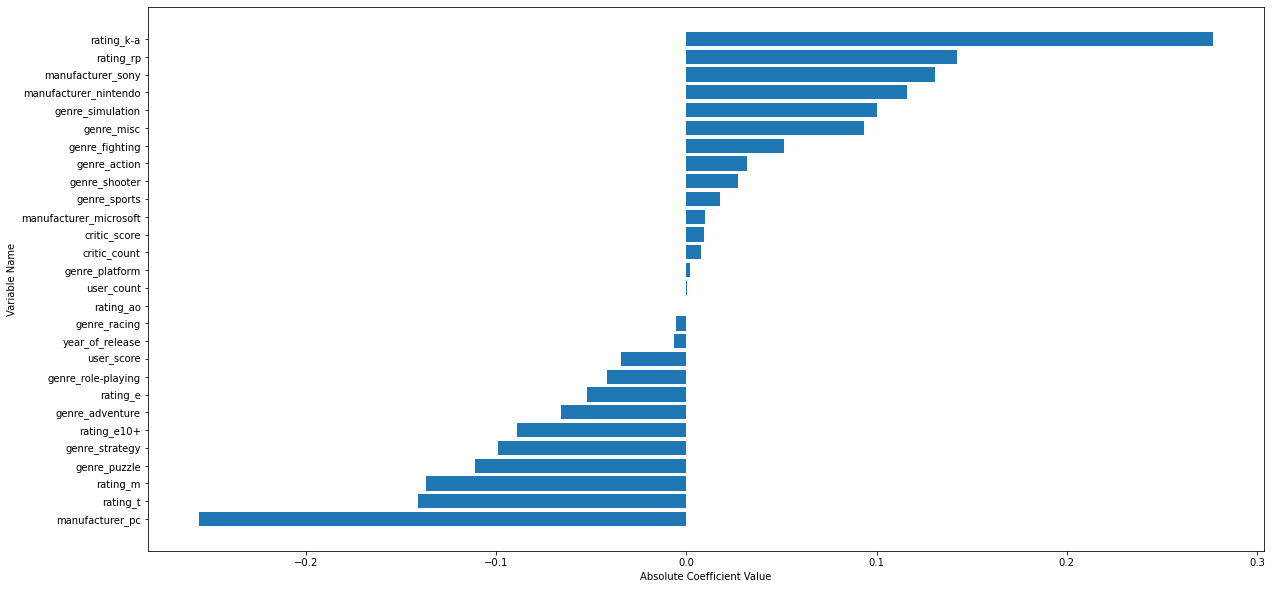

In [54]:
#plot of the coefficients of each variable
print("Average Sales: %.2f" % np.mean(vg_sales_df['global_sales']))
print("RMSE: %.2f" % np.expm1(mean_squared_error(y_test, model.predict(X_test), squared=False)))


coef_df = pd.DataFrame({'coef_mod': model.coef_[0], 'var_name': X.columns})

sorted_values, sorted_labels = zip(*sorted(zip(model.coef_[0], X.columns), reverse=False))

plt.figure(figsize=(20,10))
plt.barh(sorted_labels, sorted_values)
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Variable Name')
plt.show()

Looking at the average sales value (690k) and the RMSE (430k), one can say that the RMSE was relatively high (a forecast of 430k units sold, a value not too far from the average, may actually be a total sales failure and result in 0 sales).

If we compare with the historical analysis done before the modeling, we also find some divergences:

Rating:
- K-A rating and RP are the variables with the highest index, while in the initial analysis we found that these variables were a minority (RP even not even appearing in the database). Even after artificially filling the data with the 'mode',these values remained very low and it does not make much sense to be as determinants of large number of sales.

Manufacturer:
- Here in fact it was found that Sony, Nintendo and Microsoft manufacturers are the most determinants, which was found in the initial analysis.

Genre:
- The genre variable was left in the middle ground. Some values make sense, like 'action', 'sports' and 'shooter', which are the top 3 best selling genres. But there is a divergence when assigning a high index to the simulation genre, for example, which was the fourth worst.

The model ended up performing in an average way and it is necessary to do more tests to obtain a more faithful model.